## Code - AIM-3 Presentation

    Title: KMeans++ vs KMeans|| Clustering: Critical Evaluation of Spark vs Dask ML (using real-world data)
    Author: Anna Hedström
    Date: 23 Nov 2018


#### 1. Import 'standard' libraries.

In [42]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm #print(matplotlib.cm.cmap_d.keys())
%matplotlib inline
import seaborn as sns
sns.set()

import imageio
from pylab import rcParams
import warnings; warnings.filterwarnings("ignore", category=DeprecationWarning)

#### 2. Configure Dask ML.

In [ ]:
from dask.distributed import Client

# Run once!

# Create a local cluster with as many workers as cores for a single machine. 
client = Client(name='KMeans_Benchmark', processes=False)  #threads_per_worker=4, n_workers=1, memory_limit='2GB'
client 

In [44]:
#client.close()

#### 3. Configure Spark [PySpark].

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

# Run once!

spark = SparkSession.builder.appName('KMeans_Benchmark').config(conf=SparkConf()).master('local[*]').getOrCreate() #master("local[4]")
sc = spark.sparkContext
sql_sc = SQLContext(sc)
spark.newSession()

In [46]:
#sc.stop(); spark.stop()

### 4. Generate Dataset for testing.

In [47]:
from sklearn.datasets.samples_generator import make_blobs

import dask_ml.datasets
import dask_ml.cluster

from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler

def generate_datasets(seed=123, dist_arrays=False, spherical=False, uneven_size=False, plot=True, n_samples=100000, chunks=1000, 
                      random_state=0, centers=4, cluster_std=0.75, init_max_iter=2, oversampling_factor=10):

    # For reproducibility.
    np.random.seed(seed)
    
    # Use dask_ml.datasets.make_blobs to generate some random Dask Arrays.
    DAR, y = dask_ml.datasets.make_blobs(n_samples=n_samples, chunks=chunks, random_state=random_state, centers=centers, cluster_std=cluster_std)
    DAR = DAR.persist(); print(DAR)

    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
    
    if spherical:
        trans = [[-0.75, -0.5], [-0.55, -0.905]]
        X = np.dot(X, trans)
            
    if uneven_size:
        D, y = make_blobs(n_samples=100000, random_state=0, cluster_std=0.99)
        X_filtered = np.vstack((D[y == 0][:99000], D[y == 1][:990], D[y == 2][:10]))
        
    # Fit the data to color by the cluster that each point belongs to.
    km = dask_ml.cluster.KMeans(n_clusters=centers, init_max_iter=init_max_iter, oversampling_factor=oversampling_factor)
    km.fit(X)
    
    if plot:
        # Plot a sample of points.
        plt.subplots(figsize=(10, 8))
        plt.ylabel("x2", fontsize=12); plt.xlabel("x1", fontsize=13) #plt.title("Generated Dataset ", fontsize=14)
        plt.scatter(X[::10, 0], X[::10, 1], marker='.', c=km.labels_[::10], cmap='viridis_r', alpha=0.5)
        
        if spherical:
            # Make predictions!
            y_km_dask = km.predict(X)
            centers_dask = km.cluster_centers_
            plt.title('KMeans|| Clustering: Dask-ML', fontsize=14)
            plt.scatter(centers_dask[:, 0], centers_dask[:, 1], c='black', marker='*', s=300, alpha=0.5)
        
        plt.show()
    
    # Cannot infer Dask Array data type so we need to convert for PySpark DataFrame- and RDD API.
    # PySpark DataFrame API
    
    #if dist_arrays:
        #X = np.array(X)
        
    df_pd = pd.DataFrame(X) 
    df_ = sql_sc.createDataFrame(df_pd) 

    # The train method of MLib DataFrame API requires a DataFrame with a Vector as features.
    vectorAssembler = VectorAssembler(inputCols=["0", "1"], outputCol="features")
    DF = vectorAssembler.transform(df_)
    
    # The train method of MLib RDD-based API requires an RDD as input.
    RDD = sc.parallelize(X)
    
    return X, DAR, DF, RDD


#### 4.2 Run Data

dask.array<concatenate, shape=(100000, 2), dtype=float64, chunksize=(1000, 2)>


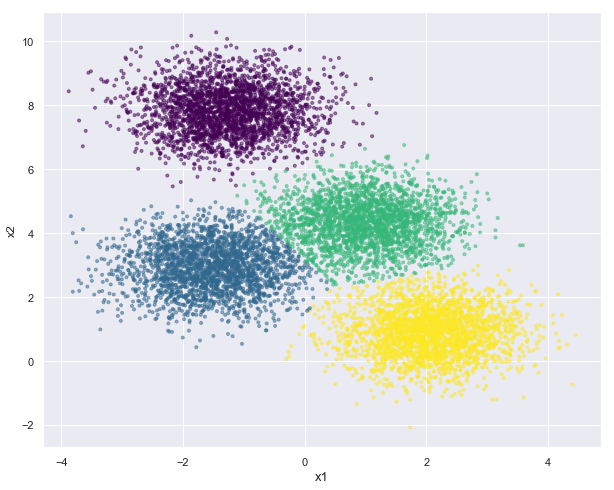

In [80]:
# Generate datasets for the first exercise. 
X, DAR, DF, RDD = generate_datasets(centers=4, cluster_std=0.75, n_samples=100000)

### 5. Implement KMeans methods in sklearn, Dask ML and PySpark.

#### 5.1 sklearn.cluster.KMeans - Numpy Arrays 

In [72]:
from sklearn.cluster import KMeans as KMeansSK

# Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

def sklearn_kmeans(seed=123, data=X, plot=True, details=True, n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                   precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=None, algorithm='full'):
    
    # For reproducibility.
    np.random.seed(seed)
    
    # Train the model and time it!
    start = time.process_time()
    km_sk = KMeansSK(n_clusters=n_clusters, algorithm=algorithm, random_state=seed, n_init=n_init, max_iter=max_iter, tol=tol)
    model_sk = km_sk.fit(X) 
    end = time.process_time()
    
    time_sec = float(end-start)
    
    # Calculate sum of distances of samples to their closest cluster center.
    ssd = model_sk.inertia_
    
    if details:
        print('Time (sec) for *vanilla* Scikit-Learn:', str(time_sec))
        print('Sum of distances of samples to closest cluster center:', str(ssd), '\n')
        print('Configuration:', str(km_sk), '\n')
    
    # Make predictions!
    y_km_sk = km_sk.predict(X) 
    centers_sk = km_sk.cluster_centers_

    if plot:
        # Plot it!
        plt.figure(figsize=(10,8)) #X_blob 
        plt.scatter(X[:, 0], X[:, 1], c=y_km_sk, s=50, cmap='viridis_r', marker='.')
        plt.scatter(centers_sk[:, 0], centers_sk[:, 1], c='black', marker='o', s=300, alpha=0.25)
        plt.ylabel('x2', fontsize=12); plt.xlabel('x1', fontsize=13)
        plt.title('KMeans++ Clustering: Scikit-Learn', fontsize=14) 
        plt.show()
    
    return time_sec, ssd


#### 5.2 dask_ml.cluster.KMeans - Dask Arrays

In [73]:
import dask_ml.cluster

# Documentation: http://ml.dask.org/modules/generated/dask_ml.cluster.KMeans.html

def dask_kmeans(seed=123, dist_array=False, dar=DAR, data=X, plot=True, details=True, n_clusters=4, init='k-means||', oversampling_factor=2, max_iter=300, tol=0.0001, 
                precompute_distances='auto', random_state=None, copy_x=True, n_jobs=1, algorithm='full', init_max_iter=None):
    
    # For reproducibility.
    np.random.seed(seed)
    
    # Train the model and time it!
    start = time.process_time()
    km_dask = dask_ml.cluster.KMeans(n_clusters=n_clusters, random_state=seed, oversampling_factor=oversampling_factor, max_iter=max_iter, 
                                     tol=tol, init_max_iter=init_max_iter)
    if dist_array:
        model_dask = km_dask.fit(DAR) 
    else:
        model_dask = km_dask.fit(X) 
    end = time.process_time()

    time_sec = float(end-start)
    
    # Calculate the KMeans cost which is the sum of squared distances of points to their nearest center.
    ssd = model_dask.inertia_

    if details:
        print('Time (sec) for Dask ML:', str(time_sec))
        print('Sum of distances of samples to closest cluster center:', str(ssd), '\n')
        print('Configuration:', str(km_dask), '\n')
    
    # Make predictions!
    y_km_dask = km_dask.predict(X)
    centers_dask = km_dask.cluster_centers_

    if plot:
        # Plot it!
        plt.subplots(figsize=(10,8))
        plt.ylabel('x2', fontsize=12); plt.xlabel('x1', fontsize=13)
        plt.title('KMeans|| Clustering: Dask-ML', fontsize=14)
        plt.scatter(X[:, 0], X[:, 1], c=y_km_dask, s=50, cmap='viridis_r', marker='.')
        plt.scatter(centers_dask[:, 0], centers_dask[:, 1], c='black', marker='*', s=300, alpha=0.5)
        plt.show()
        
    return time_sec, ssd
    

#### 5.3 pyspark.ml.clustering - DataFrame API

In [74]:
from pyspark.ml.clustering import KMeans as KMeansDF
from pyspark.ml.evaluation import ClusteringEvaluator

# Documentation: https://spark.apache.org/docs/2.4.0/ml-clustering.html 
# https://spark.apache.org/docs/2.4.0/api/python/pyspark.ml.html#pyspark.ml.clustering.KMeans

def pyspark_df_kmeans(seed=123, df=DF, data=X, plot=True, details=True, k_clusters=4, featuresCol='features', predictionCol='prediction',
                      initMode='k-means||', initSteps=2, tol=0.0001, maxIter=20, distanceMeasure='euclidean'):
    
    # For reproducibility.
    np.random.seed(seed)
    
    # Train the model and time it!
    start = time.process_time()
    km_py_df = KMeansDF(k=k_clusters, maxIter=maxIter, seed=seed, tol=tol, initSteps=initSteps)
    model_py_df = km_py_df.fit(DF)
    end = time.process_time()

    time_sec = float(end-start)
    
    # Calculate the KMeans cost which is the sum of squared distances of points to their nearest center.
    ssd = model_py_df.computeCost(DF)

    if details:
        print('Time (sec) for PySpark DataFrame-based API:', str(time_sec))
        print('Sum of distances of samples to closest cluster center:', str(ssd), '\n')
        print('Configuration:', str(km_py_df.explainParams()), '\n')

    # Make predictions!
    pred = model_py_df.transform(DF).select("prediction"); pred_ = pred.toPandas();
    y_km_df_py = np.array(pred_).ravel()
    centers_df_py = model_py_df.clusterCenters()
    centers_py_df_x = [i[0] for i in centers_df_py]
    centers_py_df_y = [i[1] for i in centers_df_py]

    if plot:
        # Plot it!
        plt.subplots(figsize=(10,8))
        plt.ylabel('x2', fontsize=12); plt.xlabel('x1', fontsize=13)
        plt.title('KMeans|| Clustering: PySpark DataFrame API', fontsize=14)
        plt.scatter(X[:, 0], X[:, 1], c=y_km_df_py, s=50, cmap='viridis_r', marker='.')
        plt.scatter(centers_py_df_x, centers_py_df_y, c='black', marker='H', s=300, alpha=0.5)
        plt.show()
        
    return time_sec, ssd
        

#### 5.4 pyspark.mllib.clustering - RDD API

In [75]:
from pyspark.mllib.clustering import KMeans as KMeansRDD, KMeansModel as KMeansModelRDD

# Documentation: https://spark.apache.org/docs/2.4.0/mllib-clustering.html
# https://spark.apache.org/docs/2.4.0/api/python/pyspark.mllib.html#pyspark.mllib.clustering.KMeans


def pyspark_rdd_kmeans(seed=123, rdd=RDD, data=X, plot=True, details=True, k_clusters=4, maxIterations=100, runs=1, 
                       initializationMode='k-means||', initializationSteps=2, epsilon=0.0001, initialModel=None):
    
    # For reproducibility.
    np.random.seed(seed)
    
    # Train the model and time it!
    start = time.process_time()
    model_py_rdd = KMeansRDD.train(rdd=RDD, k=k_clusters, epsilon=epsilon, maxIterations=maxIterations, initializationSteps=initializationSteps, seed=seed)
    end = time.process_time()

    time_sec = float(end-start)
    
    # Calculate the KMeans cost which is the sum of squared distances of points to their nearest center.
    ssd = model_py_rdd.computeCost(RDD)
    
    if details:
        print('Time (sec) for PySpark RDD-based API:', str(time_sec))
        print('Sum of distances of samples to closest cluster center:', str(ssd), '\n')
        print('Configuration:', str(model_py_rdd), '\n')

    # Make predictions!
    pred = model_py_rdd.predict(RDD); pred_ = pred.map(lambda x: (x, )).toDF(); pred__ = pred_.toPandas()
    y_km_rdd_py = np.array(pred__).ravel()
    centers_rdd_py = model_py_rdd.clusterCenters
    centers_py_rdd_x = [i[0] for i in centers_rdd_py]
    centers_py_rdd_y = [i[1] for i in centers_rdd_py]

    if plot:
        # Plot it!
        plt.subplots(figsize=(10,8))
        plt.ylabel('x2', fontsize=12); plt.xlabel('x1', fontsize=13)
        plt.title('KMeans|| Clustering: PySpark RDD API', fontsize=14)
        plt.scatter(X[:, 0], X[:, 1], c=y_km_rdd_py, s=50, cmap='viridis_r', marker='.')
        plt.scatter(centers_py_rdd_x, centers_py_rdd_y, c='black', s=300, marker='h', alpha=0.5)
        plt.show()
    
    return time_sec, ssd

#### 5.5 Run Examples

    Default Configuration

Time (sec) for *vanilla* Scikit-Learn: 8.15214600000013
Sum of distances of samples to closest cluster center: 108413.35911955957
Configuration: KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0) 



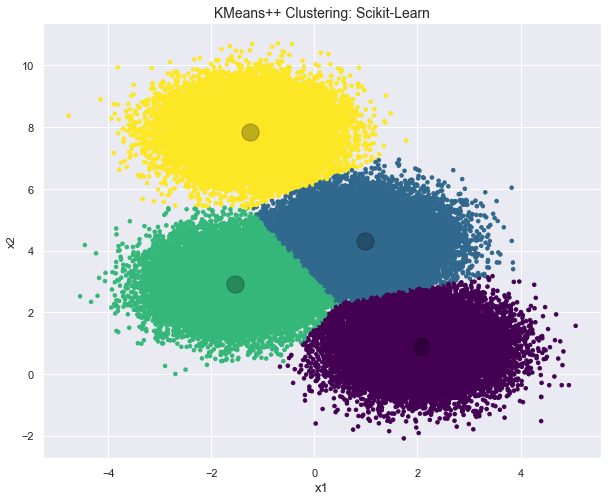

Time (sec) for Dask ML: 16.057408000000123
Sum of distances of samples to closest cluster center: 92758.4063720082
Configuration: KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=None,
    max_iter=300, n_clusters=4, n_jobs=1, oversampling_factor=2,
    precompute_distances='auto', random_state=123, tol=0.0001) 



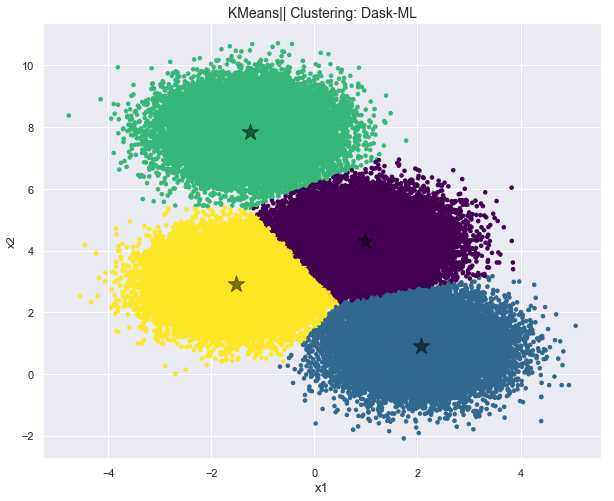

Time (sec) for PySpark DataFrame-based API: 0.2476880000001529
Sum of distances of samples to closest cluster center: 108413.34894155427
Configuration: distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)
featuresCol: features column name. (default: features)
initMode: The initialization algorithm. This can be either "random" to choose random points as initial cluster centers, or "k-means||" to use a parallel variant of k-means++ (default: k-means||)
initSteps: The number of steps for k-means|| initialization mode. Must be > 0. (default: 2, current: 2)
k: The number of clusters to create. Must be > 1. (default: 2, current: 4)
maxIter: max number of iterations (>= 0). (default: 20, current: 20)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 3323071335862364221, current: 123)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 0.0001, current: 0.0001) 



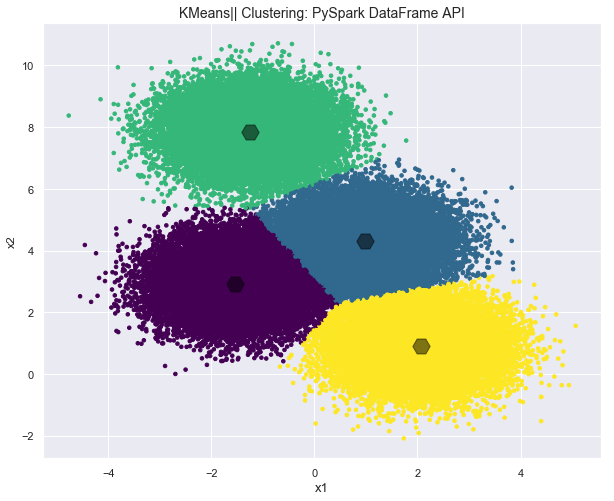

Time (sec) for PySpark RDD-based API: 0.23082799999997405
Sum of distances of samples to closest cluster center: 108413.34894155427
Configuration: <pyspark.mllib.clustering.KMeansModel object at 0x1c221948d0> 



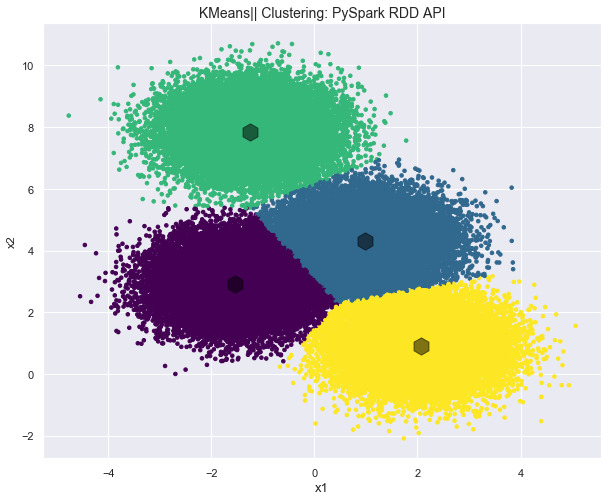

(0.23082799999997405, 108413.34894155427)

In [56]:
sklearn_kmeans(seed=123, data=X, plot=True, details=True)
dask_kmeans(seed=123, dist_array=False, dar=DAR, data=X, plot=True, details=True) # dist_array=False
pyspark_df_kmeans(seed=123, df=DF, data=X, plot=True, details=True)
pyspark_rdd_kmeans(seed=123, rdd=RDD, data=X, plot=True, details=True)

### 6. Benchmark Test 
    
    Generated Data: Isotropic Gaussian blobs.

#### 6.1 Define Global Parameters

In [58]:
# The number of clusters to form as well as the number of centroids to generate.
k = 4

# Set the standard deviation of the cluster.
std = 0.75

# Number of time the KMeans algorithm will be run with different centroid seeds, where the final results will be the best output of n_init consecutive runs in terms of inertia.
runs = 2

# Maximum number of iterations of the k-means algorithm for a single run.
iters = 50 

# Oversampling factor for use in the k-means|| algorithm.
over = 5 

# Relative change in the location of the centriods, i.e., tolerance with regards to inertia to declare convergence (when algo is terminated).
thres = 0.001

# Make randomness deterministic for reproduciability.
r = 0

#### 6.2 Generate Datasets

In [59]:
# Generate the dimensions for the dataset.
N = [10, 100, 1000, 10000, 100000, 1000000, 10000000] 

# Generate the data from the dimensions for the second exercise.
data = [make_blobs(n_samples=n, centers=k, cluster_std=std, random_state=r) for n in N]

# Retrieve only the X_test for the KMeans benchmarking.
X_test = [d[0] for d in data]

#### 6.3 Compute benchmarks
    
    Configure Hyperparameters and Plot Results for N dimensions

In [60]:
def benchmark_algorithm(seed=123, data=X_test, dims=N, plot_benchmarks=True, dist_array=False, plot=False, details=True, 
                        tol=thres, epsilon=thres, n_clusters=k, k_clusters=k, oversampling_factor=over, maxIterations=iters, max_iter=iters, 
                        init_max_iter=runs, initSteps=runs, initializationSteps=runs):
    
    time_list = []; cost_list = []; fail_list = [];
    sk_list_time = []; dask_list_time = []; py_df_list_time = []; py_rdd_list_time = []; 
    sk_list_ssd = []; dask_list_ssd = []; py_df_list_ssd = []; py_rdd_list_ssd = []; 
    fail_sk = 0; fail_dask = 0; fail_py_df = 0; fail_py_rdd = 0;
    
    np.random.seed(seed)
    
    for i, test in enumerate(X_test):
        
        print('Processing N data points:', str(dims[i]), '...\n')

        # Train Skicit-Learn.
        try:
            time_sk, ssd_sk = sklearn_kmeans(seed=seed, data=test, plot=plot, details=details, 
                                             n_init=20, max_iter=iters, tol=thres, n_clusters=n_clusters)
            sk_list_time += [time_sk]
            sk_list_ssd += [ssd_sk]
            
        except:
            print('Fail processing N data points:', dims[i], ' Scikit-Learn')
            fail_sk += 1
            sk_list_time += [np.nan]
            sk_list_ssd += [np.nan]

        # Train Dask ML.
        try:
            time_dask, ssd_dask = dask_kmeans(seed=seed, dist_array=dist_array, dar=test, data=test, plot=plot, details=details, 
                                              init_max_iter=runs, max_iter=iters, n_clusters=n_clusters, oversampling_factor=over, tol=thres)
            dask_list_time += [time_dask]
            dask_list_ssd += [ssd_dask]

        except:
            print('Fail processing N data points:', dims[i], ' Dask ML')
            fail_dask += 1
            dask_list_time += [np.nan]
            dask_list_ssd += [np.nan]
            
        # Train PySpark DataFrame API.
        try:
            pd_data = pd.DataFrame(test); df_ = sql_sc.createDataFrame(pd_data) 
            vectorAssembler = VectorAssembler(inputCols=["0", "1"], outputCol="features")
            df = vectorAssembler.transform(df_)
            time_py_df, ssd_py_df = pyspark_df_kmeans(seed=seed, df=df, data=test, plot=plot, details=details, 
                                                      maxIter=iters, tol=thres, k_clusters=n_clusters, initSteps=runs)
            py_df_list_time += [time_py_df]
            py_df_list_ssd += [ssd_py_df]

        except:
            print('Fail processing N data points:', dims[i], ' PySpark DataFrame')
            fail_py_df += 1
            py_df_list_time += [np.nan]
            py_df_list_ssd += [np.nan]
            py_df_list_time += [np.nan]
            py_df_list_ssd += [np.nan]
            
        # Train PySpark RDD API.
        try:
            rdd = sc.parallelize(test) 
            time_py_rdd, ssd_py_rdd = pyspark_rdd_kmeans(seed=seed, rdd=rdd, data=test, plot=plot, details=details, 
                                                         k_clusters=n_clusters, epsilon=thres, maxIterations=iters, initializationSteps=runs)
            py_rdd_list_time += [time_py_rdd]
            py_rdd_list_ssd += [ssd_py_rdd]
        
        except:
            print('Fail processing N data points:', dims[i], ' PySpark RDD')
            fail_py_rdd += 1
            py_rdd_list_time += [np.nan]
            py_rdd_list_ssd += [np.nan]
            
        
        time_list.append((time_sk, time_dask, time_py_df, time_py_rdd))
        cost_list.append((ssd_sk, ssd_dask, ssd_py_df, ssd_py_rdd))
        fail_list.append((fail_sk, fail_dask, fail_py_df, fail_py_rdd))
        
    if plot_benchmarks:
        plt.figure(figsize=(10,6))
        plt.plot(dims, sk_list_time, '-o', c='darkcyan', label='Scikit-Learn')
        plt.fill_between(dims, 0, sk_list_time, facecolor='darkcyan', alpha=0.05)
        plt.plot(dims, dask_list_time, '-*', c='darkorange', label='Dask ML')
        plt.fill_between(dims, 0, dask_list_time, facecolor='darkorange', alpha=0.05)
        plt.plot(dims, py_df_list_time, '-D', c='rebeccapurple', label='PySpark DataFrame API')
        plt.fill_between(dims, 0, py_df_list_time, facecolor='rebeccapurple', alpha=0.05)
        plt.plot(dims, py_rdd_list_time, '-^', c='magenta', label='PySpark RDD API')
        plt.fill_between(dims, 0, py_rdd_list_time, facecolor='magenta', alpha=0.05)
        plt.xscale('log')
        plt.yscale('log')
        #plt.title('Performance Benchmark - KMeans||', fontsize='14')
        plt.ylabel('Logarithm of Fit Time ($s$)', fontsize='14')
        plt.xlabel('Data size $N$', fontsize='14')
        plt.legend(bbox_to_anchor=(1.04,0.75), loc="upper left", fontsize='12')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10,6))
        plt.plot(dims, sk_list_ssd, '-o', c='darkcyan', label='Scikit-Learn')
        plt.fill_between(dims, 0, sk_list_ssd, facecolor='darkcyan', alpha=0.05)
        plt.plot(dims, dask_list_ssd, '-*', c='darkorange', label='Dask ML')
        plt.fill_between(dims, 0, dask_list_ssd, facecolor='darkorange', alpha=0.05)
        plt.plot(dims, py_df_list_ssd, '-D', c='rebeccapurple', label='PySpark DataFrame API')
        plt.fill_between(dims, 0, py_df_list_ssd, facecolor='rebeccapurple', alpha=0.05)
        plt.plot(dims, py_rdd_list_ssd, '-^', c='magenta', label='PySpark RDD API')
        plt.fill_between(dims, 0, py_rdd_list_ssd, facecolor='magenta', alpha=0.05)
        plt.xscale('log')
        plt.yscale('log')
        #plt.title('Performance Benchmark - KMeans||', fontsize='14')
        plt.ylabel('Logarithm of Cost ($SSD$)', fontsize='14')
        plt.xlabel('Data size $N$', fontsize='14')
        plt.legend(bbox_to_anchor=(1.04,0.75), loc="upper left", fontsize='12')
        plt.grid(True)
        plt.show()

    return time_list, cost_list, fail_list


#### 6.4 Run Tests
    
    Compute Performance Benchmarks

Processing N data points: 10 ...
Time (sec) for *vanilla* Scikit-Learn: 15.503003999999919
Sum of distances of samples to closest cluster center: 108413.498790473
Configuration: KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.001, verbose=0) 

Time (sec) for Dask ML: 4.271095999999943
Sum of distances of samples to closest cluster center: 92759.25324637801
Configuration: KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=2,
    max_iter=50, n_clusters=4, n_jobs=1, oversampling_factor=5,
    precompute_distances='auto', random_state=123, tol=0.001) 

Time (sec) for PySpark DataFrame-based API: 0.2658979999998792
Sum of distances of samples to closest cluster center: 108413.35071806527
Configuration: distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)
featuresCol: features column name. (default: featur

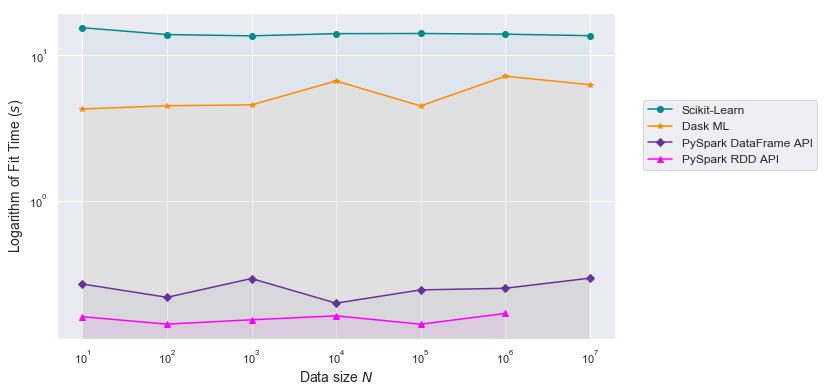

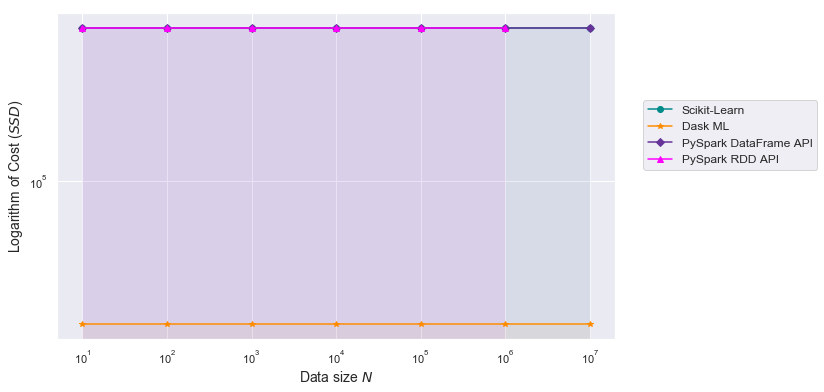

In [61]:
time_benchmark, cost_benchmark, fail_list = benchmark_algorithm(seed=123, data=X_test, dims=N, plot_benchmarks=True, dist_array=False, plot=False, details=True)

### 7. Test Scalability on 'Real-World' Data

    Images Source: http://starbridgepartners.com/2018/04/edu-video-apache-flink-a-quick-guide-to-the-next-generation-stream-processing-platform/

#### 7.1 Load Images
    
    Choose from 'Flower', 'Apache' and 'Kevin'

Before reshape: (575, 870, 3)
After reshape: (500250, 3)


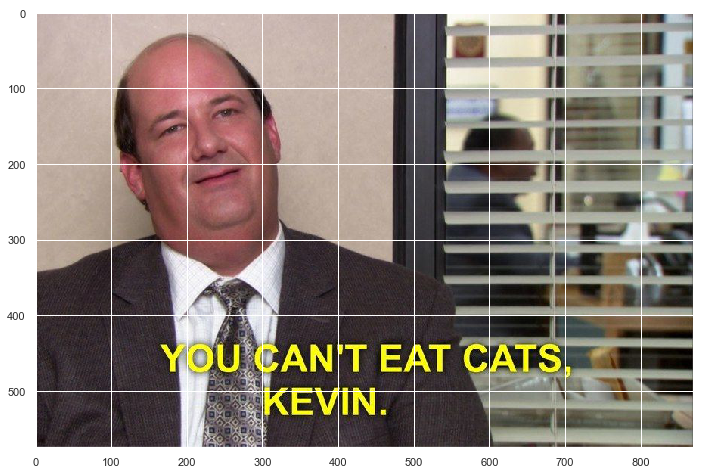

In [83]:
from sklearn.datasets import load_sample_image

# Load image: {trump.jpg, flink.jpg, flower.jpg}
img = imageio.imread('kevin.jpg')
img = np.array(img)
# img = load_sample_image("flower.jpg") 

# Plot the image
plt.figure(figsize=(12, 8))
plt.imshow(img)

# This image can be seen as 3-dimensional RGB color space 575*870*3=500250.
# Divide by 255 so that plt.imshow works well on float data. Reshape to 2D numpy array.
print('Before reshape:', img.shape)
img_r = (img / 255.0).reshape(-1,3)
print('After reshape:', img_r.shape)

#### 7.2 Define Global Parameters 

In [88]:
# The number of clusters to form as well as the number of centroids to generate.
n_colors = 75

# Number of time the KMeans algorithm will be run with different centroid seeds, where the final results will be the best output of n_init consecutive runs in terms of inertia.
runs = 2

# Maximum number of iterations of the k-means algorithm for a single run.
iters = 50

# Oversampling factor for use in the k-means|| algorithm.
over = 5 

# Relative change in the location of the centriods, i.e., tolerance with regards to inertia to declare convergence (when algo is terminated)
thres = 0.001

# Make randomness deterministic for reproduciability.
r = 0

#### 7.3 Compute Color Compressions

    Scikit-Learn, Dask ML and PySpark RDD-based API

In [89]:
''' Scikit-Learn '''

a = time.process_time()
k_colors_sk = KMeansSK(n_clusters=n_colors, n_init=10, max_iter=iters, tol=thres, random_state=r).fit(img_r)
y_pred_sk = k_colors_sk.predict(img_r)
b = time.process_time()

print('Time (sec) for *vanilla* Scikit-Learn:', str(b-a))

newimg_sk = k_colors_sk.cluster_centers_[k_colors_sk.labels_]

print('Before newimg_sk:', newimg_sk.shape)
newimg_sk = np.reshape(newimg_sk, (img.shape))
print('After newimg_sk:', newimg_sk.shape)

''' Dask ML '''

c = time.process_time()
k_colors_dask = dask_ml.cluster.KMeans(n_clusters=n_colors, init_max_iter=runs, max_iter=iters, oversampling_factor=over, tol=thres, random_state=r).fit(img_r) 
y_pred_dask = k_colors_dask.predict(img_r)
d = time.process_time()

print('Time (sec) for Dask ML:', str(d-c))

newimg_dask = k_colors_dask.cluster_centers_[k_colors_dask.labels_]

print('Before newimg_dask:', newimg_dask.shape)
newimg_dask = np.reshape(newimg_dask, (img.shape))
print('After newimg_dask:', newimg_dask.shape)


''' PySpark RDD API '''

# The train method of MLib RDD API requires a RDD as features.
img_r_ = sc.parallelize(img_r)

# PySpark tends to get job aborted for certain images, therefore we keep track if we fail.
try:
    fail = 0
    e = time.process_time()
    k_colors_py = KMeansRDD.train(rdd=img_r_, k=n_colors, maxIterations=iters, seed=r, epsilon=thres, initializationSteps=runs)
    y_pred_py = k_colors_py.predict(img_r_)
    f = time.process_time()

    print('Time (sec) for Pyspark RDD-based API:', str(f-e))

    labels = np.array(y_pred_py.collect())
    img_ix = np.array(k_colors_py.clusterCenters)
    newimg_py = img_ix[labels]

    print('Before newimg_py:', newimg_py.shape)
    newimg_py = np.reshape(newimg_py, (img.shape))
    print('After newimg_py:', newimg_py.shape)

except:
    fail = 1
    print('Fail - Job aborted')
    newimg_py = img

Time (sec) for *vanilla* Scikit-Learn: 558.6983840000003
Before newimg_sk: (500250, 3)
After newimg_sk: (575, 870, 3)


Found fewer than 75 clusters in init.


Time (sec) for Dask ML: 72.58669399999962
Before newimg_dask: (500250, 3)
After newimg_dask: (575, 870, 3)
Time (sec) for Pyspark RDD-based API: 2.4460399999998117
Before newimg_py: (500250, 3)
After newimg_py: (575, 870, 3)


In [96]:
print("k_colors_dask.cluster_centers_.shape", k_colors_dask.cluster_centers_.shape)
print("k_colors.labels_.shape ", k_colors_dask.labels_.shape) 

k_colors_dask.cluster_centers_.shape (75, 3)
k_colors.labels_.shape  (500250,)


#### 7.4 Plot Results 

    'Raw' vs 'Compressed' Image

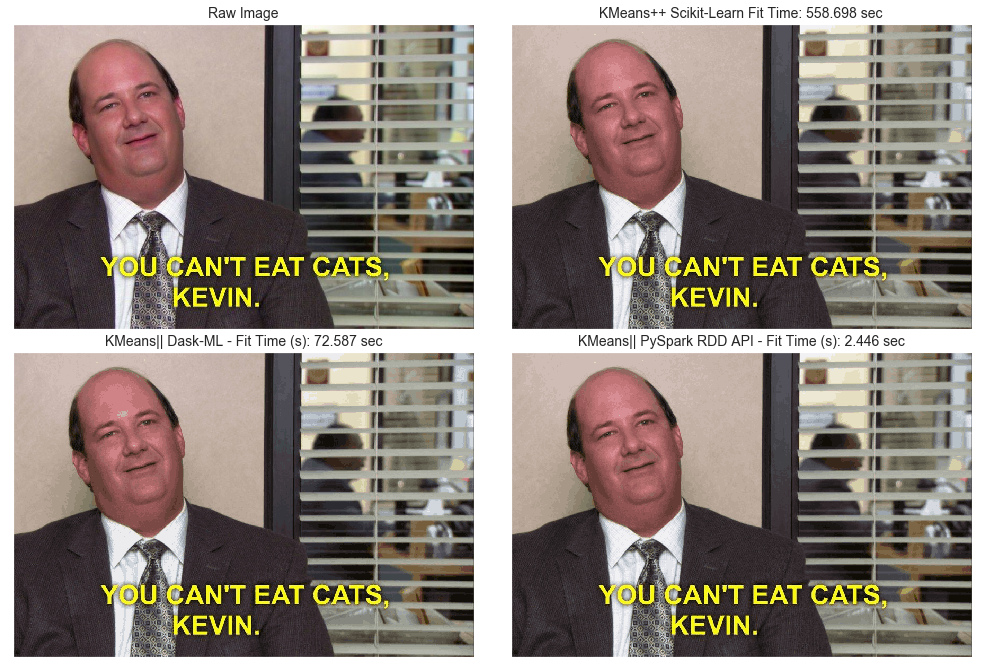

In [90]:
plt.rc('axes', titlesize=14)
plt.rc('figure', titlesize=14)

fig = plt.figure(figsize=(14,10))
#plt.suptitle("Performance Benchmark Image Colour Compression - Scalable KMeans++")

ax1 = fig.add_subplot(2, 2, 1, xticks=[], yticks=[], title='Raw Image')
ax1.imshow(img)

ax2 = fig.add_subplot(2, 2, 2, xticks=[], yticks=[], title=('KMeans++ Scikit-Learn Fit Time: ' + str(np.round((b-a), 3))) + ' sec')
ax2.imshow(newimg_sk)

ax3 = fig.add_subplot(2, 2, 3, xticks=[], yticks=[], title=('KMeans|| Dask-ML - Fit Time (s): ' + str(np.round((d-c), 3))) + ' sec')
ax3.imshow(newimg_dask)

if fail:
    ax4 = fig.add_subplot(2, 2, 4, xticks=[], yticks=[], title=('KMeans|| PySpark RDD API - Fit Time (s): Job Aborted'))
    ax4.imshow(img)
if not fail:
    ax4 = fig.add_subplot(2, 2, 4, xticks=[], yticks=[], title=('KMeans|| PySpark RDD API - Fit Time (s): ' + str(np.round((f-e), 3))) + ' sec')
    ax4.imshow(newimg_py)
    
fig.tight_layout(rect=[0, 0.03, 1, 0.96])

### 8. Evaluate Properties
    
     Generated Data: Anisotropicly distributed data
     
     Incorrect Number of Clusters.

#### 8.1 Run Experiments

In [76]:
# Re-generate datasets for the second exercise. 
X, DAR, DF, RDD = generate_datasets(plot=False, centers=4, random_state=0)

dask.array<concatenate, shape=(100000, 2), dtype=float64, chunksize=(1000, 2)>


Time (sec) for PySpark DataFrame-based API: 0.18462399999998524
Sum of distances of samples to closest cluster center: 423152.8441902488 

Configuration: distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)
featuresCol: features column name. (default: features)
initMode: The initialization algorithm. This can be either "random" to choose random points as initial cluster centers, or "k-means||" to use a parallel variant of k-means++ (default: k-means||)
initSteps: The number of steps for k-means|| initialization mode. Must be > 0. (default: 2, current: 2)
k: The number of clusters to create. Must be > 1. (default: 2, current: 2)
maxIter: max number of iterations (>= 0). (default: 20, current: 20)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 3323071335862364221, current: 123)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 0.0001, current: 0.0001) 



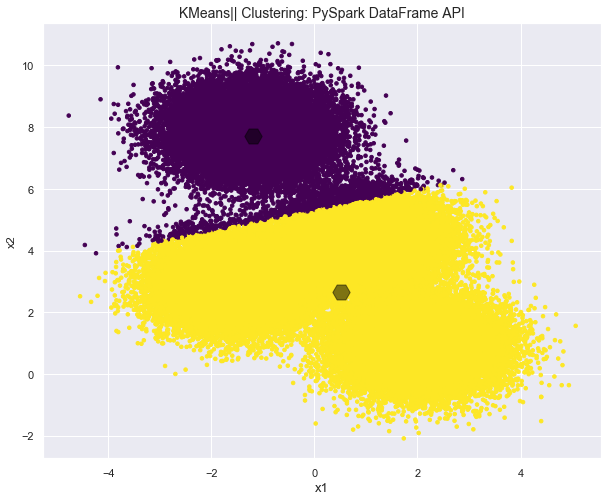

(0.18462399999998524, 423152.8441902488)

In [77]:
# 1. Assumes we know 𝑘 ahead of time (while in fact there could be an incorrect number of clusters) 
k=2
pyspark_df_kmeans(seed=123, df=DF, data=X, plot=True, details=True, k_clusters=k)

Time (sec) for PySpark DataFrame-based API: 0.2580980000002455
Sum of distances of samples to closest cluster center: 82595.53556024702 

Configuration: distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)
featuresCol: features column name. (default: features)
initMode: The initialization algorithm. This can be either "random" to choose random points as initial cluster centers, or "k-means||" to use a parallel variant of k-means++ (default: k-means||)
initSteps: The number of steps for k-means|| initialization mode. Must be > 0. (default: 2, current: 2)
k: The number of clusters to create. Must be > 1. (default: 2, current: 7)
maxIter: max number of iterations (>= 0). (default: 20, current: 20)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 3323071335862364221, current: 123)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 0.0001, current: 0.0001) 



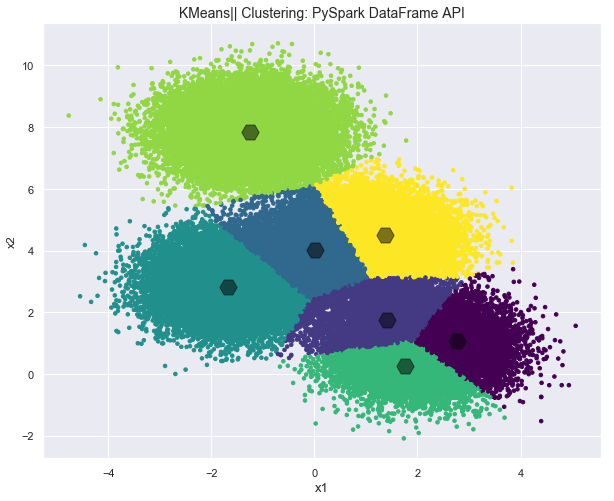

(0.2580980000002455, 82595.53556024702)

In [78]:
# 1. Assumes we know 𝑘 ahead of time (while in fact there could be an incorrect number of clusters) 
k=7
pyspark_df_kmeans(seed=123, df=DF, data=X, plot=True, details=True, k_clusters=k)

dask.array<concatenate, shape=(100000, 2), dtype=float64, chunksize=(1000, 2)>


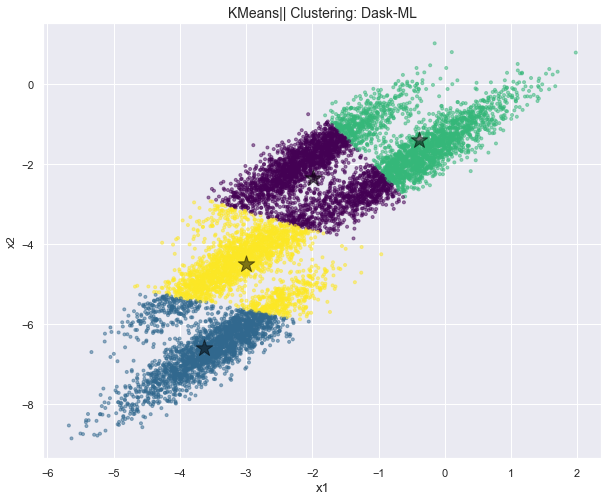

In [79]:
# 2. Assumes clusters are spherical in shape (while in fact blobs could be distributed differently)
X_ansio, DAR_ansio, DF_ansio, RDD_ansio = generate_datasets(spherical=True, plot=True)